# IIR Filter with NMigen tutorial

Good morning to everyone reading this. As part of a project, I dealt a little with Migen and NMigen. The aim of the project work was to create IIR filters with NMigen in order to be able to transfer them to Verilogcode with the help of Yosys. This document explains how anyone, using a few simple commands in Python, can create IIR filters up to order 4 in Verilog. <br>
### TOC
* Software needed
* IIR filter theory
* Creating and simulating an IIR filter with python
* Recreating the IIR filter with python with fixpoint arithmetic
* Creation and simulating an IIR filter with nmigen
* Generation of verilog code step by step 
* Results

# Software

## Anaconda and Python

In this document Windows 10 is used as the operating system. <br>
The software used here is Anaconda and the latest Python version 3.8.1. <br>
To download and install Anaconda as well as Python the following link can be used. <br>
[Click here](https://docs.anaconda.com/anaconda/install/windows/) <br>
After the installation of the newest version of Anaconda and Python, Anaconda Prompt <br>
can be started by using the Windows search box. Click the search box at the bottom left of your screen to get started. <br>
By default, the search window shows the top apps you use, as well as recent activities, <br>
so you can easily click on the programs and files you use most.<br>
Type in the searchbox 'Anaconda Prompt' and start the App.<br>

## Pip and git

For a good work flow the pip installer is one of the most used features in python. <br>
It allows to pull easily new packages and updates for python tools like the Python math library 'numpy'.<br>
Pip can be installed with the following simple input into Anaconda Prompt. <br>

*conda install pip*

# A few more librarys

It's too many to describe, so here the very short form: <br>
* numpy        (to create the filters)
* scipy        (a lot of mathematical stuff)
* matplotlib   (to plot the results with python)
* migen        (A Python toolbox for building complex digital hardware)
* nmigen       (A further development of migen)

*pip install numpy* <br>
*pip install scipy* <br>
*pip install matplotlib* <br>
*pip install migen* <br>
*pip install nmigen* <br>

# Yosys

Nmigen uses Yosys as their translator which is a stand-alone software, and must be installed at your PC. <br>
I use Windows, so I downloaded Yosys from here: http://www.clifford.at/yosys/download.html <br>
To use Yosys, you have to make it accessible for Windows. Type in your Google search: "windows path variable". <br>
Follow the steps and add a variable with the location, where you have installed Yosys on your PC. <br>
*** It is important to paste the full path including the name of the .exe *** <br>
It should look like this:

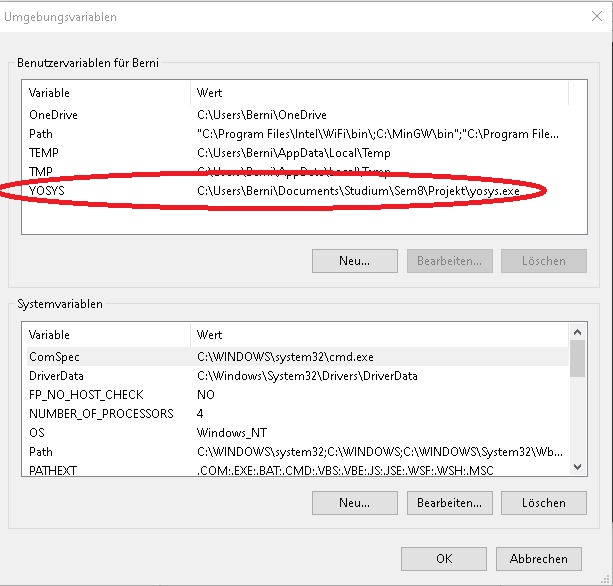

In [1]:
from IPython.display import Image
Image("img/PathVariables.JPG")

# Some IIR filter theory

Infinite impulse response (IIR) is a property applying to many linear time-invariant systems that are distinguished by having an impulse response f(t) which does not become exactly zero past a certain point, but continues indefinitely. This is in contrast to a finite impulse response (FIR) system in which the impulse response does become exactly zero at times t > T for some finite T, thus being of finite duration.

## Why IIR? FIR is doing a good job!

The main advantage digital IIR filters have over FIR filters is their efficiency in implementation, in order to meet a specification in terms of passband, stopband, and ripple. Such a set of specifications can be accomplished with a lower order IIR filter than would be required for an FIR filter meeting the same requirements. If implemented in a signal processor, this implies a correspondingly fewer number of calculations per time step; the computational savings is often of a rather large factor. IIR filters can achieve a given filtering characteristic using less memory than a similar FIR filter.

## Nice so let's only uns IIR filters!

No because they have also their problems: <br>
They are more susceptible to problems of finite-length arithmetic, such as noise generated by calculations. <br>
They are harder (slower) to implement using fixed-point arithmetic. <br>
IIR filters have a nonlinear phase response. <br>
IIR filters can become unstable, which can't happen to FIR filters. <br>

## Direct-form 1 (DF1) and Direct-form 2 (DF2)

DF1 is the form that realizes the IIR filter with the lowest possible number of multiplication stages for a given transmission form and only requires an accumulator to add up the individual partial results. A minor disadvantage of this structure, however, is that the implementation requires a relatively large number of delay elements to be implemented.<br> 
<br>
In contrast to the network structure shown above, the DF2 only requires half as many delay elements, which means that two accumulators are required in the implementation.

In [2]:
from IPython.display import HTML, display 
display(HTML("<table><tr><td><img src='img/DF1.png'></td><td><img src='img/DF2.png'></td></tr></table>")) 

,


# Creating and simulating an IIR filter with python (DF1)

For the first test, a IIR filter (DF1) is created with python. <br>
The IIR Filter is a second order Butterworh lowpass filter <br>
A simple sine function is fed into the filter and a both, input and output are displayed. <br>
All calculations are made with floatingpoint <br>

Filter Coefs: coefa and coefb:
[ 1.         -1.9962976   0.99630444] [1.71030589e-06 3.42061178e-06 1.71030589e-06]


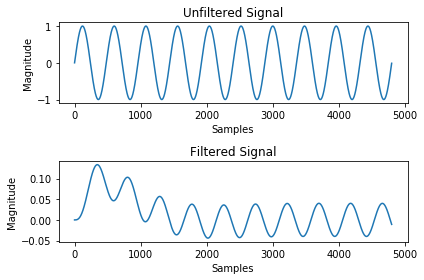

In [3]:
import matplotlib.pyplot as plt          #For plotting
from math import sin, pi                 #For generating input signals
import scipy.signal as sig               #For generating the iir filter

####################### The filter DF1 ################
def filter(x , coefb, coefa):
    y = [0]*len(x)                       #Empty array with the length 48000
    
    for n in range(0, len(x)):           #Run the filter for the len of the input signal (x) times
        y[n] = coefa[0]*y[n]
        for m in range(len(coefb)):
            y[n] = y[n] +  (coefb[m]*x[n-m] -(coefa[m]*y[n-m]))
        
    return y                             #Return the output of the filter
###################################################


############ Create the filter ####################
Fs = 48000           #Sample Frequ
sample = 48000       #Number of Samples
n = 2                #Order of Filter 
fc = 20              #Cut Frequ [Hz]
w_c = 2*fc/Fs        #Digital Frequ -> 0 - 0.5
rs = 20              #Stopband in db

[coefb,coefa] = sig.iirfilter(n,w_c ,0,rs, btype="lowpass", analog=False, ftype="butter")   #Butterworth lowpass iir filter 
print("Filter Coefs: coefa and coefb:")
print(coefa,coefb)
####################################################


################### Create the input ###############
input = [0]*sample          #empty input array
output = [0]*sample         #empty output array

frequency = 100            #frequency of the test/input signal
for i in range(48000):
    input[i] = sin(2 * pi * frequency * i / sample)
####################################################
    
    
############ Run the signal through the filter #####
output = filter(input,coefb,coefa)
####################################################


### Plot the signals for comparison ################
plt.figure(1)
plt.subplot(211)
plt.ylabel('Magnitude')
plt.xlabel('Samples')
plt.title('Unfiltered Signal')
plt.plot(input[0:4800])
plt.subplot(212)
plt.ylabel('Magnitude')
plt.xlabel('Samples')
plt.title('Filtered Signal')
plt.plot(output[0:4800])
plt.tight_layout()
plt.show()


# What to learn from this?

At first it is clearly visible, the filter does his job and lowers the amplitude. <br>
A further importante information is that there is a small overshoot as well as a small delay. <br>
The third and most important information comes from the Coefficients themselves: <br>
The coefa values are not that big -> around +-1 to +-2 but the coefb are really really small -> around 1x10^-6 <br>
This is important for calculation with arithmetics which can only handle fixpoint numbers like some FPGAs can.

# Recreating the IIR filter with python with fixpoint arithmetic

The first step to change the whole system to fixpoint arithmetic ist to find the number of bit's needed to display the smalles coeficient. <br>
The self-made function minExp uses the given coefficients coefa and coefb, which are stored in lists and extracts the smallest as well as the biggest absolute number of them both. The function also takes a given internal register size. The function returns the smallest possible exponent to shift your coefficients with, as well as the biggest possible for the given register size.

In [4]:
###Find the smallest possible exponent out of coefa and coefb ###########
def minExp (lista,listb,maxsize):
    if maxsize == "int16":
        maxsize = 16
    elif maxsize == "int32":
        maxsize = 32
    elif maxsize == "int64":
        maxsize = 64
    else:
        raise TypeError("The Exponent must be an Integer")
    lista =  [abs(ele) for ele in lista]                            #Generates a List of absolute Values
    listb =  [abs(ele) for ele in listb]                            #Generates a List of absolute Values
    minall = min(min(lista), min(listb))                            #find the minimum of the two new lists
    maxall = max(max(lista), max(listb))                            #find the maximum of the two new lists
    Expmin = int(round(0.5 + math.log(1/minall, 2)))               #find the minimum Exponent
    Expmax = int(round(math.log((2**(maxsize-1))/maxall, 2)))       #find the maximum Exponent
    print(print("Expmin = \n", Expmin))
    print(print("Expmax = \n", Expmax))
    if Expmin > Expmax:
        raise OverflowError("Filter is not possible, enlarge the internal Register or define the specs in another way")
    return Expmin,Expmax                                            #return this two found Exponents
#########################################################################

The next thing needed is a function, which scales up the coefficients and stores them in a nonfixpoint variable like an "int". <br>
This is realized with the self-made function "Multiplyer"

In [5]:
###Used to do test for the needed exponent ##############################
def Multiplyer (coefa,coefb,Exponent):
    print(coefa,coefb)
    for c in range(len(coefa)):
        coefa[c] = np.int(coefa[c]*2**Exponent)        #Takes the coefficients an multiplys it with 2**Exp then cuts the fract bits
    coefa = coefa.astype(Type)
    print(coefa)
    for c in range(len(coefb)):
        coefb[c] = int(coefb[c]*2**Exponent)        #Takes the coefficients an multiplys it with 2**Exp then cuts the fract bits
    coefb = coefb.astype(Type)
    print(coefb)
    return coefa,coefb
########################################################################

Now then input data for the wanted filter must be expanded:

In [6]:
############ Create the filter ####################
Fs = 48000           #Sample Frequ
sample = 48000       #Number of Samples
n = 2                #Order of Filter 
fc = 20              #Cut Frequ [Hz]
w_c = 2*fc/Fs        #Digital Frequ -> 0 - 0.5
rs = 20              #Stopband in db
Type = "int32"      #Type of the internal calc

[coefb,coefa] = sig.iirfilter(n,w_c ,0,rs, btype="lowpass", analog=False, ftype="butter")   #Butterworth lowpass iir filter 
print("Filter Coefs: coefa and coefb:")
print(coefa,coefb)
####################################################

Filter Coefs: coefa and coefb:
[ 1.         -1.9962976   0.99630444] [1.71030589e-06 3.42061178e-06 1.71030589e-06]


Before we can call "minExp and "Multiplyer" some includes must be done and the filter must be expanded:

In [7]:
import math
import numpy as np
from scipy.signal import chirp


##################### The filter DF1 ##########################
def filter(x , coefb, coefa,Exponent):
    y = [0]
    for n in range(0, len(x)):
        y.append(coefa[0]*y[n]/(2**Exponent))
        for m in range(len(coefb)):
            y[n] = y[n] +  (coefb[m]*x[n-m] -(coefa[m]*y[n-m]))/(2**Exponent)
    return y
#################################################################

Now the both functions "minExp" and "Multiplyer" must be called

In [8]:
Expmin,Expmax = minExp(coefa,coefb,Type)           # Call the function minExp with the given coefficients and the register size defined as Type
[coefa,coefb] = Multiplyer(coefa,coefb,Expmin)     # Call the function Multiplyer to get the coefficients scaled with Expmin

Expmin = 
 20
None
Expmax = 
 30
None
[ 1.         -1.9962976   0.99630444] [1.71030589e-06 3.42061178e-06 1.71030589e-06]
[ 1048576 -2093269  1044700]
[1 3 1]


In the last step, the input function must be created and scaled before it gets filtered. <br>
A new input function is used to display the function of the filter better.

In [9]:
input = [0]*sample
output = [0]*sample

input = chirp(t=np.linspace(0, 1, sample), f0=20, f1=100, t1=1, method='linear')*2**Expmin
output = filter(input,coefb,coefa,Expmin)

The same output like the one before is used for the input -> output comparison:

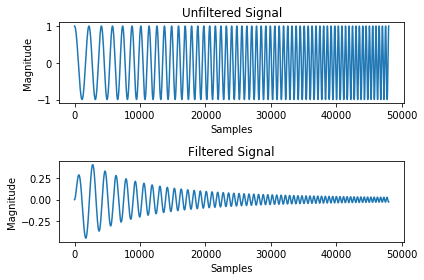

In [10]:
### Plot the signals for comparison ################
output_section = output[0:48000]
output_section = [i / (2**Expmin) for i in output_section]
input_section = input[0:48000]
input_section = [i / (2**Expmin) for i in input_section]
plt.figure(1)
plt.subplot(211)
plt.ylabel('Magnitude')
plt.xlabel('Samples')
plt.title('Unfiltered Signal')
plt.plot(input_section)
plt.subplot(212)
plt.ylabel('Magnitude')
plt.xlabel('Samples')
plt.title('Filtered Signal')
plt.plot(output_section)
plt.tight_layout()
plt.show()

That looks pretty awesome, so lets go to the next Step -> the integration of this filter in nmigen

# Creation and simulating an IIR filter with nmigen
A refreshed Python toolbox for building complex digital hardware <br>

In this project, I started to learn migen and then slowly migrated vom migen to nmigen. <br>
The Migen step is not necessary here, so I decided to cut this out. <br>
Migen and nmigen are not very different, but there are claims online that the verilog code generator does not always deliver what you expect from migen, ander therefore nmigen with yosys as translation unit will be used. <br>
Tutorials for nmigen and the migration from migen to nmigen can be found here:<br>
http://blog.lambdaconcept.com/doku.php?id=nmigen:tutorial <br>
https://github.com/RobertBaruch/nmigen-tutorial <br>
So lets jump right into nmigen: <br>
At firs the nmigen librarys must be included.

In [11]:
from scipy import signal
from nmigen import *
from nmigen.back.pysim import *
from nmigen.cli import main
from nmigen.compat import *
import matplotlib.pyplot as plt
import numpy as np
import wave, struct
import math

from functools import reduce
from operator import add
from scipy.signal import chirp
from math import cos, pi
from nmigen import *


The filter which is to be created this time is a little bit different than the last two, but never the less the function looks nearly the same. <br>
Instead of Type wsize is now used to define the max. input of the filter in bit. <br>

In [19]:
### Create the filter #######################
Fs = 48000           #Sample Frequ
samples = 48000      #Number of Samples
n = 2                #Order of Filter
fc = 100            #Cut Frequ
w_c = 2*fc/Fs        #Digital Frequ -> 0 - 0.5
wsize = 32           #Wordlength
#########################################################

The function "minExp" and "Multplyer" just changed a little:

In [20]:
### Find the smallest possible exponent out of coefa and coefb ###########
def minExp (lista,listb,maxsize):
    lista =  [abs(ele) for ele in lista]                            #Generates a List of absolute Values
    listb =  [abs(ele) for ele in listb]                            #Generates a List of absolute Values
    minall = min(min(lista), min(listb))                            #find the minimum of the two new lists
    maxall = max(max(lista), max(listb))                            #find the maximum of the two new lists
    Expmin = int(round(0.49 + math.log(1/minall, 2)))               #find the minimum Exponent
    Expmax = int(round(math.log((2**(maxsize-1))/maxall, 2)))       #find the maximum Exponent
    print(print("Expmin = \n", Expmin))
    print(print("Expmax = \n", Expmax))
    if Expmin > Expmax:
        raise OverflowError("Filter is not possible, enlarge the internal Register or define the specs in another way")
    return Expmin,Expmax                                            #return this two found Exponents
#########################################################################

In [21]:
### Used to do test for the needed exponent ##############################
def Multiplyer (coefa,coefb,Exponent):
    print(coefa,coefb)
    for c in range(len(coefa)):
        coefa[c] = np.int(coefa[c]*2**Exponent)        #Takes the Coeficients an multiplys it with 2**Exp then cuts the fract bits
    coefa = coefa.astype("int")
    print(coefa)
    for c in range(len(coefb)):
        coefb[c] = int(coefb[c]*2**Exponent)           #Takes the Coeficients an multiplys it with 2**Exp then cuts the fract bits
    coefb = coefb.astype("int")
    print(coefb)
    return coefa,coefb
########################################################################

## The IIR filter with nmigen
Here is a lot of new stuff, I tried to describe it the best I can with comments.

In [22]:
###################### The filter DF1 #################################
class iir(Elaboratable):                                    # create new class with the name iir which is a Elaboratable
    def __init__(self, num,den, Exponent=16, wsize=32):     # num = coefa den = coefb
        self.coefa = num                                    # The given values must be stored in internal registers of the iir class 
        self.coefb = den
        self.wsize = wsize
        self.i = Signal(signed(self.wsize))               # i is the input register with the size of wsize
        self.o = Signal(signed(self.wsize))               # o is the output register with the size of wsize
        self.Exponent = Exponent                          # Exponent can be Expmax or Expmin -> must be chosen before

    def elaborate(self, platform):
        m = Module()

        b_sigs = []                                       # Create an empty array for all signals from b
        for i in range(len(self.coefb)):                  # Create a empty array with signals double the size of the coeficents and the amount of b coeficiants
            b_sigs.append(Signal(signed(self.wsize*2)))   # Double the size of the max wordlenght is needed to avoid overflows

        m.d.comb += b_sigs[0].eq(self.i)                  # The first part of the b_sigs array is connected to the input signal in the combinatorial domain of the module

        for i in range(1, len(self.coefb)):               # The other b-sigs of the array are always connectet to their last one with the clock domain
            m.d.sync += b_sigs[i].eq(b_sigs[i-1])         # With ever positive edge of the clock there will be a downshift of information trough the array

        a_sigs = []                                       # Create an empty array for all signals from a
        for i in range(len(self.coefa)):                  # Create a empty array with signals double the size of the coeficents and the amount of a coeficiants
            a_sigs.append(Signal(signed(self.wsize*2)))   # Double the size of the max wordlenght is needed to avoid overflows

        m.d.comb += a_sigs[0].eq(self.o)                  # The first part of the b_sigs array is connected to the output signal in the combinatorial domain of the module

        for i in range(1, len(self.coefa)):               # The other a-sigs of the array are always connectet to their last one with the clock domain except the first one!!!!
            m.d.sync += a_sigs[i].eq(a_sigs[i-1])         # With ever positive edge of the clock there will be a downshift of information trough the array

        outputSum = 0                                     # This is a empty variable used for adding and substracting all componets of the filter
        for i in range(len(self.coefb)):
            outputSum += b_sigs[i]*int(self.coefb[i])     # Add everything form all b_sigs times the b coeficients positive
        for i in range(1, len(self.coefa)):
            outputSum -= a_sigs[i]*int(self.coefa[i])     # Add everything form all a_sigs times the a coeficients negative

        m.d.comb += self.o.eq(outputSum>>int(self.Exponent)) # The the overall Result and shift it times the Exponent to match the output size

        return m                                          # Return the module
    #############################################################################

## Simulation with nmigen
In Nmigen, not only can yosys verilog code be generated, it can also be simulated excellently. That is exactly what is now being done. To start a simulation a simulation environment has to be created. This requires the process to be simulated and a system clock. 

Expmin = 
 15
None
Expmax = 
 30
None
[ 1.         -1.98148851  0.98165828] [4.24433681e-05 8.48867363e-05 4.24433681e-05]
[ 1073741824 -2127607086  1054047554]
[45573 91146 45573]


C:\Users\Chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: instead of `with Simulator(fragment, ...) as sim:`, use `sim = Simulator(fragment); with sim.write_vcd(...):`
  # This is added back by InteractiveShellApp.init_path()


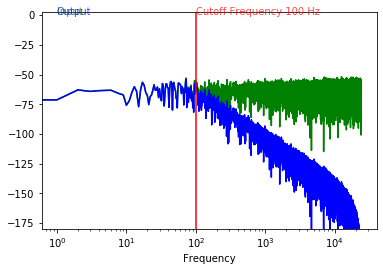

usage: ipykernel_launcher.py [-h] {generate,simulate} ...
ipykernel_launcher.py: error: argument action: invalid choice: 'C:\\Users\\Chris\\AppData\\Roaming\\jupyter\\runtime\\kernel-713119de-813c-4274-b940-19ebfec30139.json' (choose from 'generate', 'simulate')
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Chris\Anaconda3\lib\argparse.py", line 1781, in parse_known_args
    namespace, args = self._parse_known_args(args, namespace)
  File "C:\Users\Chris\Anaconda3\lib\argparse.py", line 1990, in _parse_known_args
    stop_index = consume_positionals(start_index)
  File "C:\Users\Chris\Anaconda3\lib\argparse.py", line 1946, in consume_positionals
    take_action(action, args)
  File "C:\Users\Chris\Anaconda3\lib\argparse.py", line 1839, in take_action
    argument_values = self._get_values(action, argument_strings)
  File "C:\Users\Chris\Anaconda3\lib\argparse.py", line 2379, in _get_values
    self._check_value(action, value[0])
  File "C:\Users\Chris\Anaconda3\lib\argparse.py", line 2426, in _check_value
    raise ArgumentError(action, msg % args)
argparse.ArgumentError: argument action: invalid choice: 'C:\\Users\\Chris\\AppData\\Roaming\\jupyter\\runtime\\kernel-713119de-813c-4274-b940-19ebfec30139.json' (choose from 'generate', 'simu

SystemExit: 2

C:\Users\Chris\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [30]:
################ The main function ##############################
if __name__ == "__main__":
    
    [coefb,coefa] = signal.iirfilter(n,w_c ,0, btype="lowpass", analog=False, ftype="butter")      # Butterworth lowpass iir filter 
    Expmin,Expmax = minExp(coefa,coefb,wsize)                                                      # Call the function minExp to get the smales and biggest exponent possible with the given coefficients
    [coefa,coefb] = Multiplyer(coefa,coefb,Expmax)                                                 # Call the function Multiplyer to get the coefficients scaled with Expmin
    IIR = iir(coefa,coefb,Expmax,wsize)                                                            # Genearate the Filter object IIR with the given parameters
    
#    sim = Simulator(IIR); 
#    with sim.write_vcd('export.vcd'):                                                             # write VCD-File
    with Simulator(IIR) as sim:                                                                    # Start the simulation of the IIR filter 
        def process():                                                                             # Define the process, which should be simulated
            output = []                                                                            # Create the empty output register
            f = 2**wsize                                                                           # Create the multiplier for the input function -> better readability
            input = np.random.uniform(low=-0.5, high=0.5, size=(samples))                              # New input function -> suitable for a spectrum analysis
            for i in input:
                yield IIR.i.eq(int(i*f))                                                           # Write the scaled variable [i] from the input array into the IIR Filter
                yield Tick()                                                                       # One clock tick -> all m.d.sync +-=...is done now
                output.append((yield IIR.o)/f)                                                     # ppend the scaled-down output from the IIR filter on the output array
                
            y = int(len(output)/2)                                                                 # generate an variable half the size of the leng of the output array
            H = np.fft.fft(sig.windows.hann(len(output))*output) / samples                                                                # Fastfurier transform of the whole output array
            H_half = H[:y]                                                                         # Save half of this Fastfurier transform in H_half
            N = np.fft.fft(sig.windows.hann(len(input))*input)  / samples                                                                # Same for the input array
            N_half = N[:y]
            
            fig = plt.figure()                                                                     # Drawing commands for the graphs
            ax = fig.add_subplot(111)
            ax.plot(20*np.log10(np.abs(N_half)),color = 'g')
            ax.plot(20*np.log10(np.abs(H_half)),color = 'b')
            #ax.set_yscale('log')
            ax.set_xscale('log')
            ax.set_xlabel('Frequency')
            ax.set_ylim(-180,3)
            ax.axvline(fc,color='r')
            ax.text(x=fc, y=min(np.abs(H_half)), s='Cutoff Frequency ' + str(fc) + ' Hz', alpha=0.7, color='r')
            ax.text(x=1, y=0.2, s='Input', alpha=0.7, color='g')
            ax.text(x=1, y=0.1, s='Output', alpha=0.7, color='b')
            plt.show()

        sim.add_clock(1e-9)                                                                         # Add the system clock for the Simulation = 1 GHz
        sim.add_sync_process(process)                                                               # The simulation should run the process function
        sim.run()                                                                                   # Run the simulation
        #main(IIR,ports=(IIR.i,IIR.o))                                                              # For the Yosys translation, the input and the output ports must be defined
                                                                                                    # Yosys automatically generates the clock and the reset input port

# Generation of verilog code step by step 
In order to translate the filter shown above into Verilog code, the last line of the code above must be commented out. <br>
***main(IIR,ports=(IIR.i,IIR.o))*** <br>
Combine the notebooks to one file and save it into your directory. <br>
Name the new python file something simple like IIR7.py <br>
Go to your Windows searching bar and type in Anaconda. <br>
Start Anaconda Prompt. <br>
Navigate with the cd command to the directory where the IIR7.py file is stored. <br>

In [ ]:
from IPython.display import Image
Image("img/Anaconda1.JPG")

  Run to following comand to translate the filter into verilog.  

In [ ]:
from IPython.display import Image
Image("img/Anaconda2.JPG")

The File which is generated should look like this:

In [ ]:
from IPython.display import Image
Image("img/Anaconda3.JPG")

# Result

Open the verilogfile with notepad++ , editor or vivado etc. and delete the following first rows: <br>
(* generator = "nMigen" *) <br>
(* top =  1  *) <br>
(* \nmigen.hierarchy  = "top" *) <br>
<br>
Then lets edit the Module name: module top(o, clk, rst, i); <br>
Change the Word "top" to the name the filter should have: IIR_NMIGEN <br>
The result should look like this:

In [ ]:
from IPython.display import Image
Image("img/VivadoSim5.JPG")

If clear code is needed, delete alle the comit lines like (* src = "IIR.7.py:113" *)

Let's start with the Vivado environment. <br>
At first a Stimulusfile is created, which makes a jump from 0x000000 to 0x00ffff after 1us. <br>
The Stimulusfile also creates different clock frequencys an is able to generate a sine oder other defined signals, but here only the jump should be used.<br>
It's written in vhdl. <br>
To demonstrate how a working filters should look like, I used different FIR and an IIR Filter (fcutoff = 1kHz). <br>
One FIR filter was generated form the migen FIR example. <br>
One FIR filter was generated from matlab. <br>
One IIR filter was given from a Prof. form the Munich University of Applied Sciences. <br>
Three IIR filters are from different nmigen exports, the one created above is highlighted in yellow. <br>
***Connect the rst pin of the IIR filters from nmigen with a constant with the value 0 to make them work!*** <br>
The Testbench with the different filters looks like this:

In [ ]:
from IPython.display import Image
Image("img/VivadoSim4.JPG")

Let's start the simulation and display the output of the filters. <br>
There are some warnings from Vivado that only the lower 24 bits are connected, which is totally fine because the test signal only needs the lower 16 bit. <br>
In the plot below the FIR from migen, the IIR from Munich and the IIR7 from nmigen are displayed. <br>
The step function is barely visible, but she is there.

In [ ]:
from IPython.display import Image
Image("img/VivadoSim2.JPG")

Whats left to say? <br>
That was fun, but it was a big try and error game. <br>
At least it does it's job. <br>
Great work yosys and nmigen team. <br>
To get in touch with the developers of nmigen visit: https://webchat.freenode.net/#nmigen <br>
Best Bernhard